In [1]:
import torch
import torch.nn as nn
from torchinfo import summary
import torchvision.models as models
from typing import Optional, List, Type, Union, Any

## ResNet50v1 vs ResNet50v2

![resnet34 architecture](../img/resnet50comp1.PNG)
![resnet34 architecture](../img/resnet50comp2.PNG)
![resnet34 architecture](../img/resnet50comp3.PNG)
![resnet34 architecture](../img/resnet50comp4.PNG)

## Writing ResNet50v1 architecture

In [15]:
class Bottleneck(nn.Module):
    """building block used for resnet with less than 50 layers i.e. resnet 18,34"""
    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                  downsample: Optional[nn.Module] = None, kernel_size: int = 3) -> None:
        super().__init__()
        # self.conv1 downsamples the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)
        self.conv3 = nn.Conv2d(planes, planes*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=planes*self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is None:
            shortcut = x    # identity
        else:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block: Type[Bottleneck], layers: List[int], num_classes: int = 1000,
        zero_init_residual: bool = False,) -> None:
        super().__init__()
        
        self.inplanes = 64
        self.base_width = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Bottleneck], planes: int, blocks: int, stride: int = 1, dilate: bool = False,) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [ block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append( block(self.inplanes, planes) )

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [16]:
modelv1 = ResNet(block=Bottleneck, layers=[3,4,6,3])

In [17]:
print(modelv1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
summary(modelv1, input_size=(1, 3, 224, 224),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
from torchview import draw_graph
model_graph = draw_graph(modelv1, input_size=(1, 3, 224, 224), expand_nested=True, depth=4)

model_graph.visual_graph

## Writing ResNet50v1.5 architecture

In [23]:
class Bottleneck(nn.Module):
    """building block used for resnet with less than 50 layers i.e. resnet 18,34"""
    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                  downsample: Optional[nn.Module] = None, kernel_size: int = 3) -> None:
        super().__init__()
        # self.conv1 downsamples the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)
        self.conv3 = nn.Conv2d(planes, planes*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=planes*self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is None:
            shortcut = x    # identity
        else:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)
        return out
    

class ResNetv1_5(nn.Module):
    def __init__(self, block: Type[Bottleneck], layers: List[int], num_classes: int = 1000,
        zero_init_residual: bool = False,) -> None:
        super().__init__()
        
        self.inplanes = 64
        self.base_width = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Bottleneck], planes: int, blocks: int, stride: int = 1, dilate: bool = False,) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [ block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append( block(self.inplanes, planes) )

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [25]:
modelv1_5 = ResNetv1_5(block=Bottleneck, layers=[3,4,6,3])

In [26]:
print(modelv1_5)

ResNetv1_5(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [27]:
summary(modelv1_5, input_size=(1, 3, 224, 224),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNetv1_5                               [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
from torchview import draw_graph
model_graph = draw_graph(modelv1_5, input_size=(1, 3, 224, 224), expand_nested=True, depth=4)

model_graph.visual_graph

## Validate with pytorch buildin resnet50

In [28]:
torch_modelv1_5=models.resnet50(weights=None)
print(torch_modelv1_5)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(torch_modelv1_5, input_size=(1, 3, 224, 224),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

## Writing ResNet50v2 architecture

In [22]:
class Bottleneck(nn.Module):
    """building block used for resnet with less than 50 layers i.e. resnet 18,34"""
    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                  shortcut: Optional[nn.Module] = None, kernel_size: int = 3) -> None:
        super().__init__()
        # self.conv1 downsamples the input when stride != 1
        self.bn_pre = nn.BatchNorm2d(num_features=inplanes)
        self.relu_pre = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)
        self.conv3 = nn.Conv2d(planes, planes*self.expansion, kernel_size=1, stride=1, bias=False)
        self.shortcut = shortcut
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        preact = self.bn_pre(x)
        preact = self.relu_pre(preact)
        out = self.conv1(preact)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.shortcut is None:
            shortcut = x    # identity
        else:
            if isinstance(self.shortcut, nn.Module):
                shortcut = self.shortcut(preact)
            else:
                shortcut = self.shortcut(x)

        out += shortcut
        return out
    

class ResNetv2(nn.Module):
    def __init__(self, block: Type[Bottleneck], layers: List[int], num_classes: int = 1000,
        zero_init_residual: bool = False,) -> None:
        super().__init__()
        
        self.inplanes = 64
        self.base_width = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)
        self.post_bn = nn.BatchNorm2d(512*block.expansion)
        self.post_relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Bottleneck], planes: int, blocks: int, stride: int = 1, dilate: bool = False,) -> nn.Sequential:
        shortcut = None
        shortcut = nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=1, bias=False)

        layers = [ block(self.inplanes, planes, shortcut=shortcut)]
        self.inplanes = planes*block.expansion
        for _ in range(1, blocks-1):
            layers.append( block(self.inplanes, planes) )

        if stride == 1:
            shortcut = None
        else:
            shortcut = nn.MaxPool2d(kernel_size=1, stride=stride)
            
        self.inplanes = planes*block.expansion
        layers.append( block(self.inplanes, planes, stride, shortcut) )

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.post_bn(x)
        x = self.post_relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [23]:
modelv2 = ResNetv2(block=Bottleneck, layers=[3,4,6,3])

In [24]:
print(modelv2)

ResNetv2(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (bn_pre): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_pre): ReLU(inplace=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn_pre): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [25]:
summary(modelv2, input_size=(1, 3, 224, 224),depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
ResNetv2                                 [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─BatchNorm2d: 3-1             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-2                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-5                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-6                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-8                    [1, 64, 56, 56]           --
│ 


(process:10660): Pango-WARNING **: 04:08:23.449: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


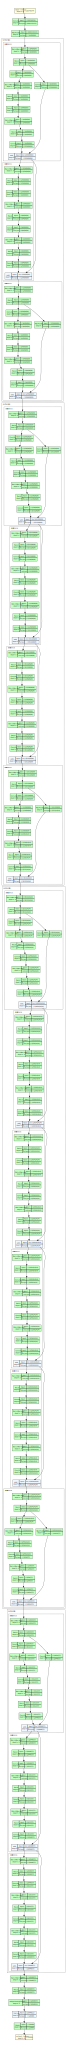

In [26]:
from torchview import draw_graph
model_graph = draw_graph(modelv2, input_size=(1, 3, 224, 224), expand_nested=True, depth=4)

model_graph.visual_graph